# Download
PBMC scRNA-seq data: https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz.

Brain snRNA-seq data in the example 1: https://github.com/LieberInstitute/10xPilot_snRNAseq-human#work-with-the-data --> HPC.

Brain snRNA-seq data in the example 2: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE164485. 

# Preprocess
We use the R codes "preprocess_pbmc3k.R" for part of preprocessing. Run "preprocess_pbmc3k.R" before using this code.

# Example 1

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import anndata2ri
import scipy.io as sio
import anndata as ad

In [2]:
ro.r['library']("DropSeq.util")
ro.r['library']("Seurat")
ro.r['library']("SingleCellExperiment")
ro.r.assign("obj.path", "./pbmc3k/pbmc.RData")
ro.r("load(obj.path)")
ro.r("cnt <- pbmc@assays$RNA@counts")
ro.r("celltype <- as.vector(pbmc$celltype)")
ro.r("rm(pbmc)")
ro.r("obj_sc <- CreateSeuratObject(counts=cnt)")
ro.r("names(celltype) <- colnames(x = obj_sc)")
ro.r("obj_sc <- AddMetaData(object = obj_sc, metadata = celltype, col.name = 'celltype')")
ro.r("sce_sc <- as.SingleCellExperiment(obj_sc)")

ro.r("load('./Raw_data_Lieber10X/SCE_HPC-n3_tran-etal.rda')")
ro.r("obj_sn_fromsce <- as.Seurat(sce.hpc.tran, counts = 'counts', data = 'logcounts')")
ro.r("obj_sn_fromsce <- obj_sn_fromsce[, obj_sn_fromsce$donor=='donor2']")
ro.r("obj_sn_fromsce <- obj_sn_fromsce[, obj_sn_fromsce$cellType!='drop.doublet']")
ro.r("obj_sn_fromsce <- obj_sn_fromsce[, obj_sn_fromsce$cellType!='drop.lowNTx_A']")
ro.r("obj_sn_fromsce <- obj_sn_fromsce[, obj_sn_fromsce$cellType!='drop.lowNTx_B']")
ro.r("cnt_sn <- obj_sn_fromsce@assays$RNA@counts")
ro.r("celltype_sn <- as.vector(obj_sn_fromsce$cellType)")
ro.r("rm(obj_sn_fromsce)")
ro.r("obj_sn <- CreateSeuratObject(counts=cnt_sn)")
ro.r("names(celltype_sn) <- colnames(x = obj_sn)")
ro.r("obj_sn <- AddMetaData(object = obj_sn, metadata = celltype_sn, col.name = 'celltype')")
ro.r("sce_sn <- as.SingleCellExperiment(obj_sn)")

anndata2ri.activate()
adata_sc = ro.r('as(sce_sc, "SingleCellExperiment")')
adata_sn = ro.r('as(sce_sn, "SingleCellExperiment")')

R[write to console]: Loading required package: data.table

R[write to console]: data.table 1.13.6 using 22 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: Loading required package: Matrix

R[write to console]: 
Seurat v4 will be going to CRAN in the near future;
 for more details, please visit https://satijalab.org/seurat/v4_changes


R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to 

In [3]:
import portal

# Specify the GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Create a folder for saving results
result_path = "./result_PBMC3k-Lieber10X"
if not os.path.exists(result_path):
    os.makedirs(result_path)

In [4]:
meta = pd.concat([adata_sc.obs, adata_sn.obs])

In [5]:
model = portal.model.Model(training_steps=1000, lambdacos=50.0)
model.preprocess(adata_sc, adata_sn, hvg_num=4000) # perform preprocess and PCA
model.train() # train the model
model.eval() # get integrated latent representation of cells

Finding highly variable genes...
Normalizing and scaling...


/home/jzhaoaz/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Dimensionality reduction via PCA...
Begining time:  Sat Mar 19 22:01:10 2022
step 0, loss_D=7.503440, loss_GAN=2.689643, loss_AE=103.452927, loss_cos=102.476479, loss_LA=79.664909
step 200, loss_D=0.052649, loss_GAN=9.884157, loss_AE=6.223189, loss_cos=6.881878, loss_LA=1.185391
step 400, loss_D=0.028514, loss_GAN=9.987433, loss_AE=4.171986, loss_cos=4.841224, loss_LA=0.622207
step 600, loss_D=0.047473, loss_GAN=9.971163, loss_AE=3.310652, loss_cos=4.051124, loss_LA=0.422161
step 800, loss_D=0.037632, loss_GAN=9.983760, loss_AE=3.017011, loss_cos=3.722646, loss_LA=0.345782
Ending time:  Sat Mar 19 22:01:36 2022
Training takes 25.84 seconds
Begining time:  Sat Mar 19 22:01:36 2022
Ending time:  Sat Mar 19 22:01:36 2022
Evaluating takes 0.06 seconds


UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation',
     min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1,
     verbose=True)
Construct fuzzy simplicial set
Sat Mar 19 22:01:36 2022 Finding Nearest Neighbors
Sat Mar 19 22:01:36 2022 Building RP forest with 9 trees
Sat Mar 19 22:01:37 2022 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
Sat Mar 19 22:01:44 2022 Finished Nearest Neighbor Search


/home/jzhaoaz/.conda/envs/scUNIT/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Sat Mar 19 22:01:46 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


... storing 'orig.ident' as categorical
... storing 'celltype' as categorical
... storing 'ident' as categorical


Sat Mar 19 22:02:07 2022 Finished embedding


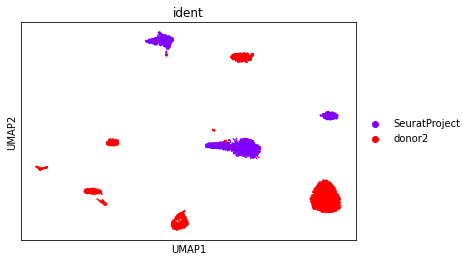

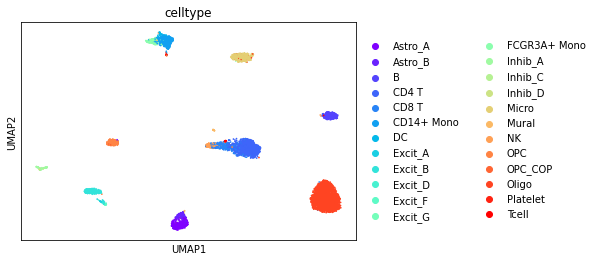

In [6]:
portal.utils.plot_UMAP(model.latent, meta, colors=["ident", "celltype"], save=True, result_path=result_path)

In [7]:
import umap
import matplotlib.pyplot as plt


reducer = umap.UMAP(n_neighbors=30,
                    n_components=2,
                    metric="correlation",
                    n_epochs=None,
                    learning_rate=1.0,
                    min_dist=0.3,
                    spread=1.0,
                    set_op_mix_ratio=1.0,
                    local_connectivity=1,
                    repulsion_strength=1,
                    negative_sample_rate=5,
                    a=None,
                    b=None,
                    random_state=1234,
                    metric_kwds=None,
                    angular_rp_forest=False,
                    verbose=True)

embedding = reducer.fit_transform(model.latent)

n_cells = embedding.shape[0]
size = 120000 / n_cells

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation',
     min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1,
     verbose=True)
Construct fuzzy simplicial set
Sat Mar 19 22:02:09 2022 Finding Nearest Neighbors
Sat Mar 19 22:02:09 2022 Building RP forest with 9 trees
Sat Mar 19 22:02:09 2022 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
Sat Mar 19 22:02:11 2022 Finished Nearest Neighbor Search
Sat Mar 19 22:02:12 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Mar 19 22:02:33 2022 Finished embedding


In [8]:
cell_type = meta['celltype']

# PBMC3k
# cell_type = cell_type.replace(np.nan, 'nan (sn cells)')
cell_type = cell_type.replace('B', 'B cell')
cell_type = cell_type.replace('CD14+ Mono', 'CD14+ Monocyte')
cell_type = cell_type.replace('CD4 T', 'CD4 T cell')
cell_type = cell_type.replace('CD8 T', 'CD8 T cell')
cell_type = cell_type.replace('DC', 'Dendritic cell')
cell_type = cell_type.replace('FCGR3A+ Mono', 'FCGR3A+ Monocyte')
cell_type = cell_type.replace('NK', 'Nature killer cell')

# cell_type = cell_type.replace(np.nan, 'nan (sc cells)')
cell_type = cell_type.replace('Astro_A', 'Astrocyte')
cell_type = cell_type.replace('Astro_B', 'Astrocyte')
cell_type = cell_type.replace('Excit_A', 'Excitatory Neuron')
cell_type = cell_type.replace('Excit_B', 'Excitatory Neuron')
cell_type = cell_type.replace('Excit_D', 'Excitatory Neuron')
cell_type = cell_type.replace('Excit_F', 'Excitatory Neuron')
cell_type = cell_type.replace('Excit_G', 'Excitatory Neuron')
cell_type = cell_type.replace('Inhib_A', 'Inhibitory Neuron')
cell_type = cell_type.replace('Inhib_C', 'Inhibitory Neuron')
cell_type = cell_type.replace('Inhib_D', 'Inhibitory Neuron')
cell_type = cell_type.replace('Micro', 'Microglia')
cell_type = cell_type.replace('OPC', 'Oligodendrocyte precursor cell')
cell_type = cell_type.replace('OPC_COP', 'Committed oligodendrocyte precursor cell')
cell_type = cell_type.replace('Oligo', 'Oligodendrocyte')
cell_type = cell_type.replace('Tcell', 'T cell (Brain)')

In [9]:
method = meta["ident"]
method = method.replace('SeuratProject', 'PBMC (cell)')
method = method.replace('donor2', 'Brain (nucleus)')

In [10]:
import matplotlib as mpl
from sklearn import preprocessing
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap

le1 = preprocessing.LabelEncoder()
label1 = le1.fit_transform(method)
colours1 = ListedColormap(["tab:blue", "tab:orange"])

le2 = preprocessing.LabelEncoder()
label2 = le2.fit_transform(cell_type)
colours2 = 'rainbow'

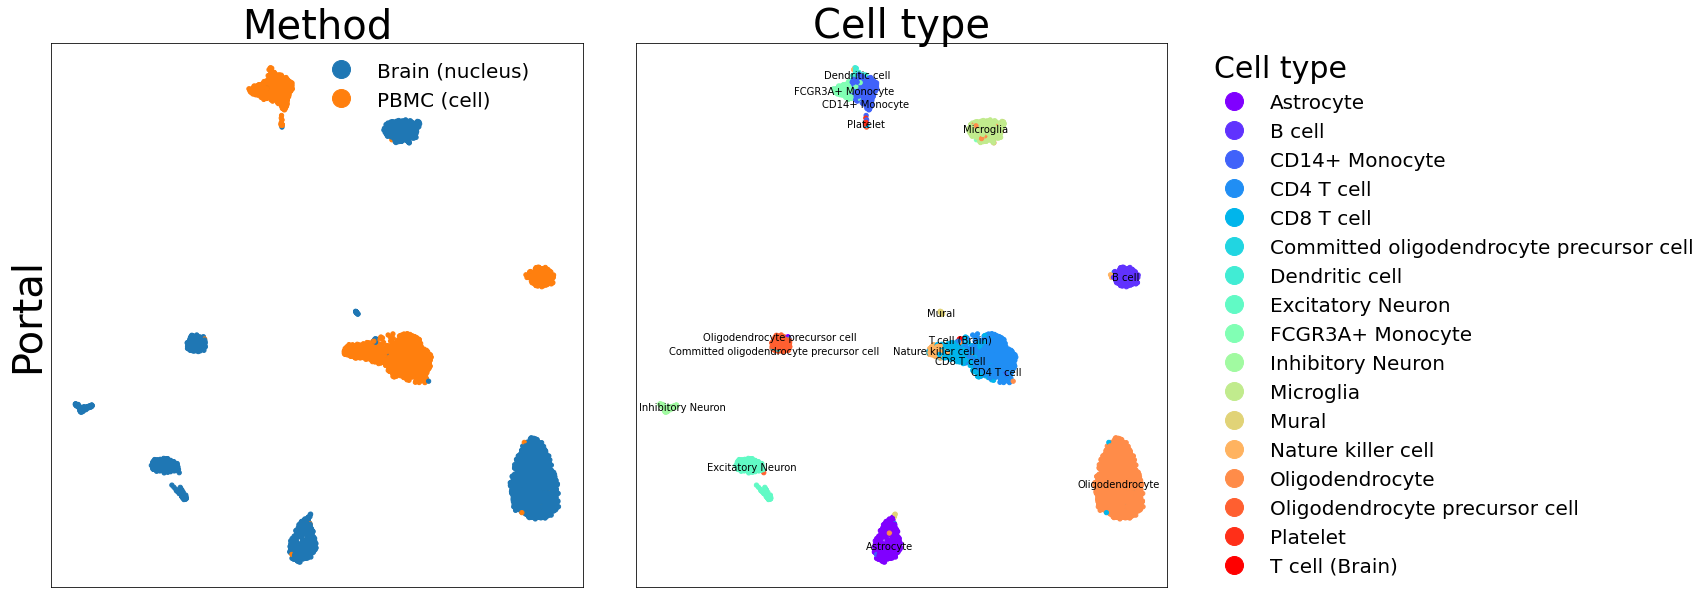

In [11]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

f = plt.figure(figsize=(20,10))

n_cells = embedding.shape[0]
size = 120000 / n_cells

np.random.seed(1234)

order = np.arange(n_cells)
np.random.shuffle(order)

ax1 = f.add_subplot(1,2,1)
scatter1 = ax1.scatter(embedding[order, 0], embedding[order, 1], s=size, c=label1[order], cmap=colours1, label=method[order])
ax1.set_title("Method", fontsize=40)
ax1.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax1.set_ylabel("Portal", fontsize=40)
ax2 = f.add_subplot(1,2,2)
scatter2 = ax2.scatter(embedding[order, 0], embedding[order, 1], s=size, c=label2[order], cmap=colours2, label=cell_type[order])
ax2.set_title("Cell type", fontsize=40)
ax2.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)

for i in list(set(cell_type)):
    coordinates = np.median(embedding[cell_type==i], axis=0)
    # Align annotations
    if i == "Inhibitory Neuron":
        coordinates = coordinates + [1.0, 0]
    if i == "Oligodendrocyte precursor cell":
        coordinates = coordinates + [0, 0.5]
    if i == "Committed oligodendrocyte precursor cell":
        coordinates = coordinates + [0, -0.2]
    if i == "CD4 T cell":
        coordinates = coordinates + [0, -0.9]
    if i == "CD8 T cell":
        coordinates = coordinates + [0, -0.5]
    if i == "CD14+ Monocyte":
        coordinates = coordinates + [0., -0.9]
    ax2.annotate(str(i), rotation=0, fontsize=10, xy=coordinates, ha='center', va='center')

l1 = f.legend(handles=scatter1.legend_elements(num=len(sorted(set(method)))-1)[0], 
              labels=sorted(set(method)), 
              loc="upper left", 
              bbox_to_anchor=(0.3, 0.88), markerscale=3., title_fontsize=20, fontsize=20, frameon=False, ncol=1)

l2 = f.legend(handles=scatter2.legend_elements(num=len(sorted(set(cell_type)))-1)[0], 
              labels=sorted(set(cell_type)), 
              loc="upper left", 
              title="Cell type",
              bbox_to_anchor=(0.92, 0.89), markerscale=3., title_fontsize=30, fontsize=20, frameon=False, ncol=1)
l2._legend_box.align = "left"

f.subplots_adjust(hspace=.1, wspace=.1)
plt.show()

# Example 2

In [12]:
dge = pd.read_csv("./Raw_data_Fullard/GSE164485_gene_expression_20210104.csv")

cellid = dge["Unnamed: 0"].values.astype(str)
geneid = dge.columns[1:].astype(str)
mat = np.array(dge.drop(columns=['Unnamed: 0']))

adata_sn = ad.AnnData(X=mat)
adata_sn.obs.index = cellid
adata_sn.var.index = geneid

adata_sn.write(filename="./Raw_data_Fullard/adata_sn.h5ad")

In [13]:
gene_df = pd.read_csv("./Raw_data_Fullard/GSE164485_variable_genes_10k_01042021.csv")

In [14]:
adata_sn_10Kgenes = adata_sn[:, list(gene_df.x.values.astype(str))]
adata_sn = adata_sn_10Kgenes.copy()

In [15]:
meta_df = pd.read_csv("./Raw_data_Fullard/GSE164485_meta_data_20210104.csv")
meta_df = meta_df.set_index('Unnamed: 0')

meta_ctrl2 = meta_df.loc[meta_df.subject_id2.values.astype(str) == "Ctrl 2"].copy()

In [16]:
adata_sn_c2 = adata_sn[meta_ctrl2.index, :].copy()
adata_sn_c2.obs["celltype"] = meta_ctrl2.celltype.values.astype(str)

In [17]:
adata_sn_c2

AnnData object with n_obs × n_vars = 7511 × 10000
    obs: 'celltype'

In [18]:
ro.r['library']("DropSeq.util")
ro.r['library']("Seurat")
ro.r['library']("SingleCellExperiment")
ro.r.assign("obj.path", "./pbmc3k/pbmc.RData")
ro.r("load(obj.path)")
ro.r("cnt <- pbmc@assays$RNA@counts")
ro.r("celltype <- as.vector(pbmc$celltype)")
ro.r("rm(pbmc)")
ro.r("obj_sc <- CreateSeuratObject(counts=cnt)")
ro.r("names(celltype) <- colnames(x = obj_sc)")
ro.r("obj_sc <- AddMetaData(object = obj_sc, metadata = celltype, col.name = 'celltype')")

ro.r("sce <- as.SingleCellExperiment(obj_sc)")

anndata2ri.activate()
adata_sc = ro.r('as(sce, "SingleCellExperiment")')

In [19]:
meta_sc = adata_sc.obs

In [20]:
adata_sn = adata_sn_c2.copy()
meta_sn = meta_ctrl2.copy()

meta_sn = meta_sn.loc[adata_sn.obs.index, :]
meta_sc = meta_sc.loc[adata_sc.obs.index, :]

meta_sn["method"] = "brain"
meta_sc["method"] = "pbmc"

meta = pd.concat([meta_sn, meta_sc])

Finding highly variable genes...
Normalizing and scaling...


/home/jzhaoaz/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Dimensionality reduction via PCA...
Begining time:  Sat Mar 19 22:10:21 2022
step 0, loss_D=6.837201, loss_GAN=2.675435, loss_AE=97.373871, loss_cos=50.486027, loss_LA=73.170471
Ending time:  Sat Mar 19 22:10:25 2022
Training takes 4.58 seconds
Begining time:  Sat Mar 19 22:10:26 2022
Ending time:  Sat Mar 19 22:10:26 2022
Evaluating takes 0.08 seconds
UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation',
     min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1,
     verbose=True)
Construct fuzzy simplicial set
Sat Mar 19 22:10:26 2022 Finding Nearest Neighbors
Sat Mar 19 22:10:26 2022 Building RP forest with 10 trees
Sat Mar 19 22:10:26 2022 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
Sat Mar 19 22:10:28 2022 Finished Nearest Neighbor Search
Sat Mar 19 22:10:29 2022 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	compl

... storing 'subject_id' as categorical
... storing 'subject_id2' as categorical
... storing 'tissue' as categorical
... storing 'pid' as categorical
... storing 'celltype' as categorical
... storing 'clinical' as categorical
... storing 'method' as categorical
... storing 'orig.ident' as categorical
... storing 'ident' as categorical


Sat Mar 19 22:10:43 2022 Finished embedding


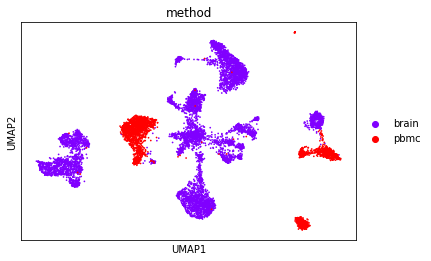

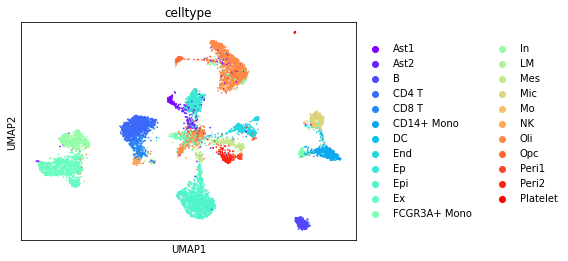

In [21]:
import portal

# Specify the GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

# Create a folder for saving results
result_path = "./result_snbrain_scpbmc"
if not os.path.exists(result_path):
    os.makedirs(result_path)
    
model = portal.model.Model(training_steps=200, lambdacos=25.0)
# model.preprocess(adata_SS2, adata_sn) # perform preprocess and PCA
model.preprocess(adata_sn, adata_sc, hvg_num=4500) # perform preprocess and PCA
model.train() # train the model
# model.eval(D_score=True) # get integrated latent representation of cells
model.eval()

portal.utils.plot_UMAP(model.latent, meta, colors=["method", "celltype"], save=True, result_path=result_path)

In [22]:
import umap
import matplotlib.pyplot as plt


reducer = umap.UMAP(n_neighbors=30,
                    n_components=2,
                    metric="correlation",
                    n_epochs=None,
                    learning_rate=1.0,
                    min_dist=0.3,
                    spread=1.0,
                    set_op_mix_ratio=1.0,
                    local_connectivity=1,
                    repulsion_strength=1,
                    negative_sample_rate=5,
                    a=None,
                    b=None,
                    random_state=1234,
                    metric_kwds=None,
                    angular_rp_forest=False,
                    verbose=True)

embedding = reducer.fit_transform(model.latent)

n_cells = embedding.shape[0]
size = 120000 / n_cells

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation',
     min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1,
     verbose=True)
Construct fuzzy simplicial set
Sat Mar 19 22:10:45 2022 Finding Nearest Neighbors
Sat Mar 19 22:10:45 2022 Building RP forest with 10 trees
Sat Mar 19 22:10:45 2022 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
Sat Mar 19 22:10:48 2022 Finished Nearest Neighbor Search
Sat Mar 19 22:10:48 2022 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Mar 19 22:11:03 2022 Finished embedding


In [23]:
cell_type = meta['celltype']

# PBMC3k
# cell_type = cell_type.replace(np.nan, 'nan (sn cells)')
cell_type = cell_type.replace('B', 'B cell')
cell_type = cell_type.replace('CD14+ Mono', 'CD14+ Monocyte')
cell_type = cell_type.replace('CD4 T', 'CD4 T cell')
cell_type = cell_type.replace('CD8 T', 'CD8 T cell')
cell_type = cell_type.replace('DC', 'Dendritic cell')
cell_type = cell_type.replace('FCGR3A+ Mono', 'FCGR3A+ Monocyte')
cell_type = cell_type.replace('NK', 'Nature killer cell')

# cell_type = cell_type.replace(np.nan, 'nan (sc cells)')
cell_type = cell_type.replace('Ast1', 'Astrocyte')
cell_type = cell_type.replace('Ast2', 'Astrocyte')
cell_type = cell_type.replace('Ex', 'Excitatory Neuron')
cell_type = cell_type.replace('In', 'Inhibitory Neuron')
cell_type = cell_type.replace('End', 'Endothelia cell')
cell_type = cell_type.replace('Ep', 'Ependymal cell')
cell_type = cell_type.replace('Epi', 'Epithelial cell')
cell_type = cell_type.replace('Mes', 'Mesenchymal cell')
cell_type = cell_type.replace('Mic', 'Microglial cell')
cell_type = cell_type.replace('LM', 'Lymphocyte')
cell_type = cell_type.replace('Mo', 'Macrophage')
cell_type = cell_type.replace('Opc', 'Dendrocyte progenitor cell')
cell_type = cell_type.replace('Oli', 'Oligodendrocyte')
cell_type = cell_type.replace('Peri1', 'Pericyte')
cell_type = cell_type.replace('Peri2', 'Pericyte')

In [24]:
method = meta["method"]
method = method.replace('pbmc', 'PBMC (cell)')
method = method.replace('brain', 'Brain (nucleus)')

In [25]:
from sklearn import preprocessing
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap

le = preprocessing.LabelEncoder()
label = le.fit_transform(method)
colours = ListedColormap(["tab:blue", "tab:orange"])

le3 = preprocessing.LabelEncoder()
label3 = le3.fit_transform(cell_type)
colours3 = 'rainbow'

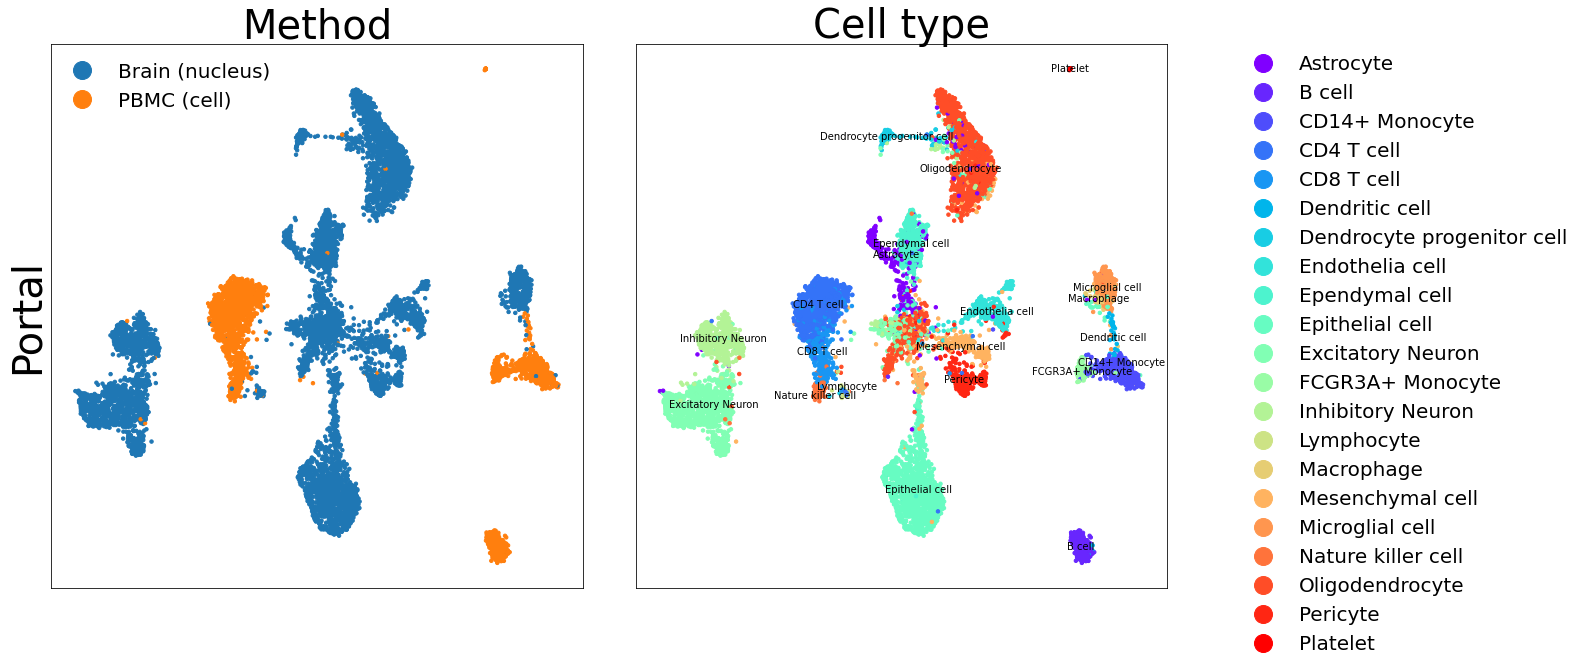

In [26]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

f = plt.figure(figsize=(20,10))

order = np.arange(n_cells)
np.random.shuffle(order)

ax1 = f.add_subplot(1,2,1)
scatter1 = ax1.scatter(embedding[order, 0], embedding[order, 1], s=size, c=label[order], cmap=colours, label=method[order])
ax1.set_title("Method", fontsize=40)
ax1.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax1.set_ylabel("Portal", fontsize=40)
ax2 = f.add_subplot(1,2,2)
scatter2 = ax2.scatter(embedding[:, 0], embedding[:, 1], s=size, c=label3, cmap=colours3, label=cell_type)
ax2.set_title("Cell type", fontsize=40)
ax2.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)

for i in list(set(cell_type)):
    coordinates = np.median(embedding[cell_type==i], axis=0)
    # Align annotations
    if i == "CD14+ Monocyte":
        coordinates = coordinates + [-0.05, 0.35]
    if i == "Astrocyte":
        coordinates = coordinates + [-0.2, -0.2]
    if i == "Lymphocyte":
        coordinates = coordinates + [0.1, 0.2]
    if i == "Nature killer cell":
        coordinates = coordinates + [-0.2, -0.2]
    ax2.annotate(str(i), rotation=0, fontsize=10, xy=coordinates, ha='center', va='center')

l1 = f.legend(handles=scatter1.legend_elements(num=len(sorted(set(method)))-1)[0], 
              labels=sorted(set(method)), 
              loc="upper left", 
              bbox_to_anchor=(0.12, 0.88), markerscale=3., title_fontsize=20, fontsize=20, frameon=False, ncol=1)

l2 = f.legend(handles=scatter2.legend_elements(num=len(sorted(set(cell_type)))-1)[0], 
              labels=sorted(set(cell_type)), 
              loc="upper left", 
              bbox_to_anchor=(0.94, 0.89), markerscale=3., title_fontsize=20, fontsize=20, frameon=False, ncol=1)

f.subplots_adjust(hspace=.1, wspace=.1)
plt.show()